In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score
import random


### Copy the 20th Frame from Each Clip to new directory

In [2]:
!mkdir tusimple_preprocessed
!cd tusimple_preprocessed && mkdir training
!cd tusimple_preprocessed/training && mkdir frames && mkdir lane-masks

clips = '/kaggle/input/tusimple/TUSimple/train_set/clips/'
new_frames = '/kaggle/working/tusimple_preprocessed/training/frames'

for i in os.listdir(clips):
    for j in os.listdir(os.path.join(clips, i)):
        frame = os.path.join(clips, i, j, '20.jpg')
        tmp = frame[:-7].split('/')[-2:]
        new_fn = f'{tmp[0]}_{tmp[1]}.jpg'
        new_file = os.path.join(new_frames, new_fn)
        shutil.copy(frame, new_file)
    print('Done with: ', i)


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Done with:  0531
Done with:  0601
Done with:  0313-2
Done with:  0313-1


### Processing Lane and Drawing Lane Masks

In [3]:
def generate_lane_mask(row, training_set=True):
    mask = np.zeros((720, 1280, 3))
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    for lane in lanes:    
        h_samples_updated = [y for x, y in zip(lane, h_samples) if x != -2]
        lane = [x for x in lane if x != -2]
        lane_points = np.array(list(zip(lane, h_samples_updated)))
        cv2.polylines(mask, [lane_points], False, (255, 255, 255), thickness=15)

    path = '/kaggle/working/tusimple_preprocessed/training/lane-masks' if training_set else '/kaggle/working/tusimple_preprocessed/test/lane-masks'
    tmp = raw_file[:-7].split('/')[-2:]
    mask_fname = f'{tmp[0]}_{tmp[1]}.jpg'
    new_file = os.path.join(path, mask_fname)
    cv2.imwrite(new_file, mask)
    return mask_fname


In [4]:
df_0601 = pd.read_json('/kaggle/input/tusimple/TUSimple/train_set/label_data_0601.json', lines=True)
df_0313 = pd.read_json('/kaggle/input/tusimple/TUSimple/train_set/label_data_0313.json', lines=True)
df_0531 = pd.read_json('/kaggle/input/tusimple/TUSimple/train_set/label_data_0531.json', lines=True)
df = pd.concat([df_0601, df_0313, df_0531])

for index, row in df.iterrows():
    generate_lane_mask(row)
    if index % 200 == 0:
        print('Row: ', index)


Row:  0
Row:  200
Row:  400
Row:  0
Row:  200
Row:  400
Row:  600
Row:  800
Row:  1000
Row:  1200
Row:  1400
Row:  1600
Row:  1800
Row:  2000
Row:  2200
Row:  2400
Row:  2600
Row:  2800
Row:  0
Row:  200


### Visualize image-mask pairs

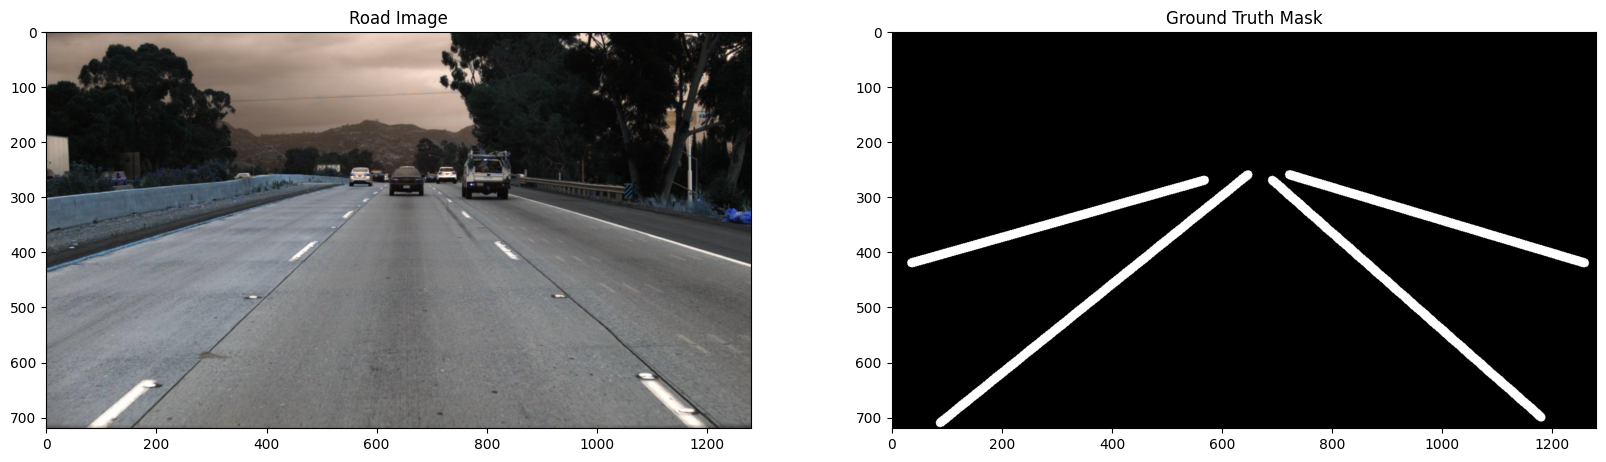

In [5]:
img_color = cv2.imread('/kaggle/working/tusimple_preprocessed/training/frames/0601_1494453497604532231.jpg')
img_mask = cv2.imread('/kaggle/working/tusimple_preprocessed/training/lane-masks/0601_1494453497604532231.jpg')

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_color/255.)
plt.title('Road Image')

plt.subplot(1, 2, 2)
plt.imshow(img_mask/255., cmap='gray')
plt.title('Ground Truth Mask')

plt.show()


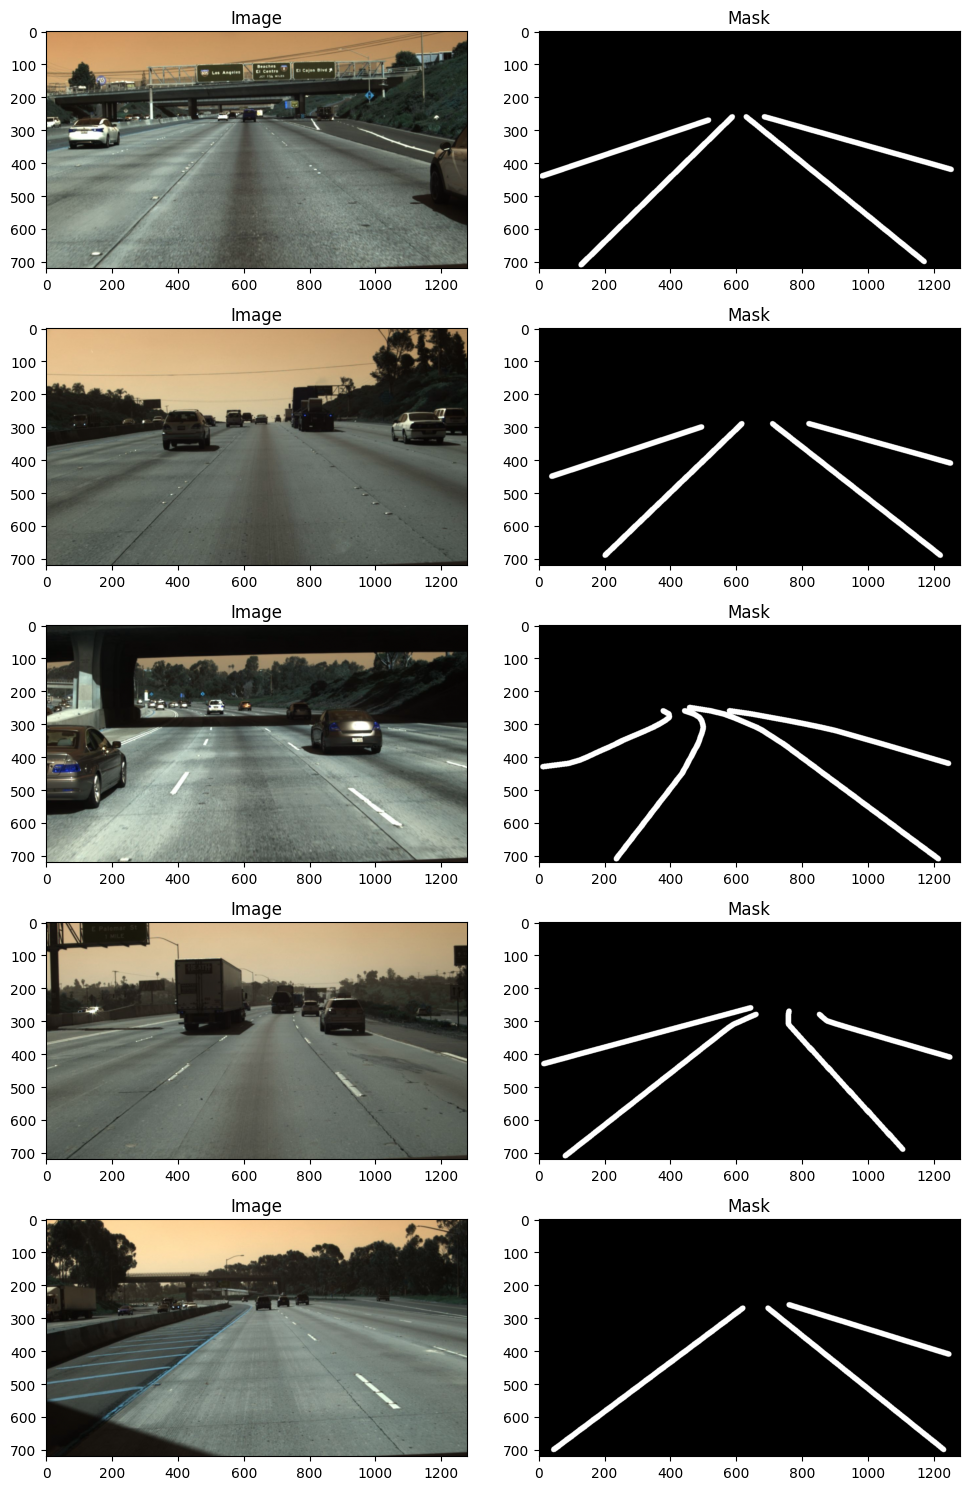

In [6]:
import random

def visualize_samples(num_samples=5):
    fig, ax = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
    
    images_path = '/kaggle/working/tusimple_preprocessed/training/frames'
    masks_path = '/kaggle/working/tusimple_preprocessed/training/lane-masks'
    
    image_files = os.listdir(images_path)
    random_samples = random.sample(image_files, num_samples)
    
    for i, img_file in enumerate(random_samples):
        img = cv2.imread(os.path.join(images_path, img_file))
        mask = cv2.imread(os.path.join(masks_path, img_file), cv2.IMREAD_GRAYSCALE)
        
        ax[i, 0].imshow(img / 255.0)
        ax[i, 0].set_title('Image')
        ax[i, 1].imshow(mask, cmap='gray')
        ax[i, 1].set_title('Mask')
    
    plt.tight_layout()
    plt.show()

# Visualize 5 samples
visualize_samples(5)

### resizing, augmenting, normalizing, and converting masks to binary

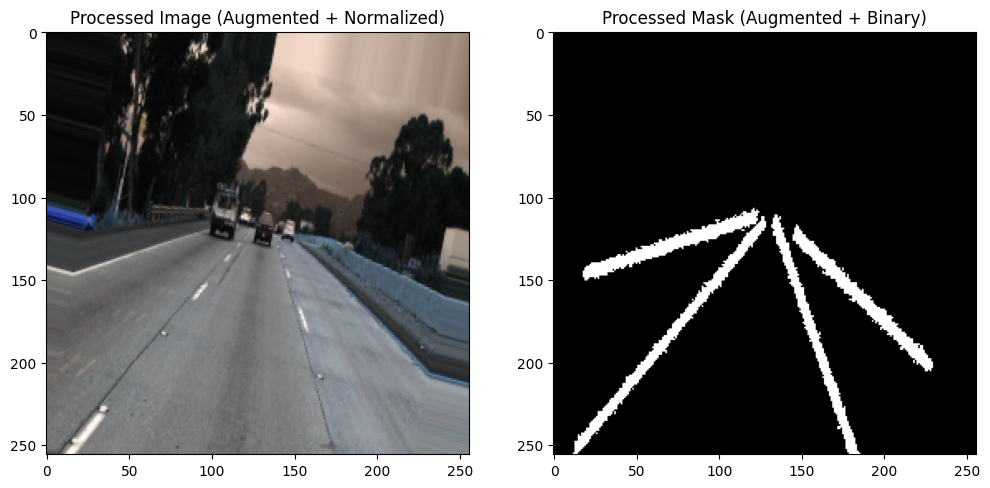

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

IMG_HEIGHT = 256
IMG_WIDTH = 256

def resize_image_and_mask(image, mask):
    
    image_resized = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    mask_resized = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    return image_resized, mask_resized

def normalize_image(image):
    
    normalized_image = image / 255.0
    return normalized_image

data_gen_args = dict(rotation_range=15,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.01,
                     zoom_range=[0.9, 1.25],
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

def augment_image_and_mask(image, mask):
    seed = np.random.randint(0, 1000)
    
    image_augmented = image_datagen.random_transform(image, seed=seed)
    mask = np.stack([mask, mask, mask], axis=-1)
    mask_augmented = mask_datagen.random_transform(mask, seed=seed)
    mask_augmented = mask_augmented[:, :, 0]
    
    return image_augmented, mask_augmented

def process_data(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Ensure mask is read as grayscale

    image_resized, mask_resized = resize_image_and_mask(image, mask)
    
    image_augmented, mask_augmented = augment_image_and_mask(image_resized, mask_resized)

    image_normalized = normalize_image(image_augmented)
    
    mask_binary = np.where(mask_augmented > 0, 1, 0)

    return image_normalized, mask_binary
    
sample_image_path = '/kaggle/working/tusimple_preprocessed/training/frames/0601_1494453497604532231.jpg'
sample_mask_path = '/kaggle/working/tusimple_preprocessed/training/lane-masks/0601_1494453497604532231.jpg'

image_processed, mask_processed = process_data(sample_image_path, sample_mask_path)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_processed)
plt.title('Processed Image (Augmented + Normalized)')

plt.subplot(1, 2, 2)
plt.imshow(mask_processed, cmap='gray')
plt.title('Processed Mask (Augmented + Binary)')

plt.show()


In [8]:
sample_image = cv2.imread(sample_image_path)
sample_mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)

print(f"Sample Image shape: {sample_image.shape}")
print(f"Sample Mask shape: {sample_mask.shape}")

Sample Image shape: (720, 1280, 3)
Sample Mask shape: (720, 1280)


### visualize the distribution of pixel intensities in an image and its corresponding mask

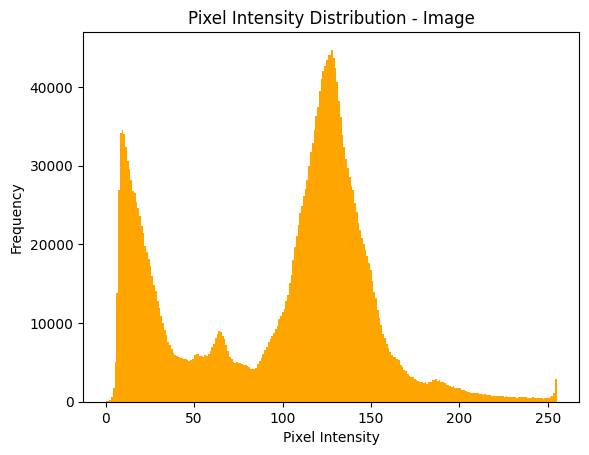

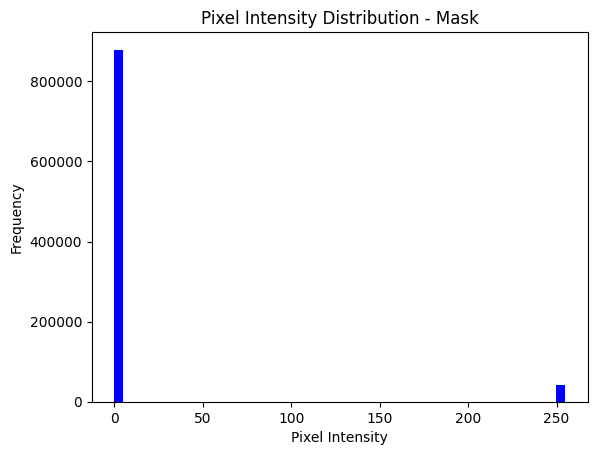

In [9]:
plt.hist(sample_image.ravel(), bins=256, color='orange', )
plt.title('Pixel Intensity Distribution - Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

plt.hist(sample_mask.ravel(), bins=50, color='blue', )
plt.title('Pixel Intensity Distribution - Mask')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

### UNet Model

In [10]:
from tensorflow.keras import layers, models
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    merge5 = layers.concatenate([conv3, up5], axis=3)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = layers.concatenate([conv2, up6], axis=3)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv1, up7], axis=3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create U-Net model
unet = unet_model()
unet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    524,544 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 512)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │    131,200 │ conv2d_9[0][0]  

 Total params: 7,697,345 (29.36 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

### SegNet model

In [11]:
def segnet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    up4 = layers.UpSampling2D(size=(2, 2))(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(up4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(up5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(up6)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv6)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create SegNet model
segnet = segnet_model()
segnet.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 256, 256, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,104,385 (8.03 MB)

 Trainable params: 2,104,385 (8.03 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

train_images_path = '/kaggle/working/tusimple_preprocessed/training/frames'
train_masks_path = '/kaggle/working/tusimple_preprocessed/training/lane-masks'


X_train = []  
Y_train = []  


for image_file in os.listdir(train_images_path):
    image_path = os.path.join(train_images_path, image_file)
    mask_path = os.path.join(train_masks_path, image_file)

    image, mask = process_data(image_path, mask_path)
    
    X_train.append(image)
    Y_train.append(mask)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

batch_size = 16
epochs = 20
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)


In [14]:
history_unet = unet.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[checkpoint])

Epoch 1/20


I0000 00:00:1729417282.300151     108 service.cc:145] XLA service 0x5a3b551ad520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729417282.300224     108 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729417282.300228     108 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729417336.150989     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


204/204 ━━━━━━━━━━━━━━━━━━━━ 234s 860ms/step - accuracy: 0.9206 - loss: 0.2915 - val_accuracy: 0.9441 - val_loss: 0.1910
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 110s 538ms/step - accuracy: 0.9452 - loss: 0.1774 - val_accuracy: 0.9475 - val_loss: 0.1591
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 110s 541ms/step - accuracy: 0.9501 - loss: 0.1444 - val_accuracy: 0.9591 - val_loss: 0.1027
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 111s 542ms/step - accuracy: 0.9630 - loss: 0.0946 - val_accuracy: 0.9665 - val_loss: 0.0834
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 111s 542ms/step - accuracy: 0.9694 - loss: 0.0767 - val_accuracy: 0.9691 - val_loss: 0.0757
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 110s 541ms/step - accuracy: 0.9720 - loss: 0.0695 - val_accuracy: 0.9726 - val_loss: 0.0693
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 110s 541ms/step - accuracy: 0.9734 - loss: 0.0653 - val_accuracy: 0.9737 - val_loss: 0.0645
Epoch 8/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 110s 541ms/step - accuracy: 0.9748 - loss: 0.06

In [15]:
history_segnet = segnet.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[checkpoint])

Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 75s 348ms/step - accuracy: 0.9411 - loss: 0.3044 - val_accuracy: 0.9473 - val_loss: 0.1617
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 68s 334ms/step - accuracy: 0.9509 - loss: 0.1401 - val_accuracy: 0.9590 - val_loss: 0.1087
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 68s 335ms/step - accuracy: 0.9610 - loss: 0.1025 - val_accuracy: 0.9639 - val_loss: 0.0927
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 68s 335ms/step - accuracy: 0.9644 - loss: 0.0922 - val_accuracy: 0.9655 - val_loss: 0.0881
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 68s 335ms/step - accuracy: 0.9673 - loss: 0.0837 - val_accuracy: 0.9668 - val_loss: 0.0851
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 68s 335ms/step - accuracy: 0.9686 - loss: 0.0802 - val_accuracy: 0.9683 - val_loss: 0.0807
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 68s 335ms/step - accuracy: 0.9700 - loss: 0.0763 - val_accuracy: 0.9701 - val_loss: 0.0756
Epoch 8/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 68s 335ms/step - accuracy: 0.9713 - loss: 0

### Predictions

Copied 0313-2_41380.jpg to test directories
Copied 0313-2_15240.jpg to test directories
Copied 0313-1_8740.jpg to test directories
Copied 0313-1_39060.jpg to test directories
Copied 0601_1495485243539258908.jpg to test directories
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


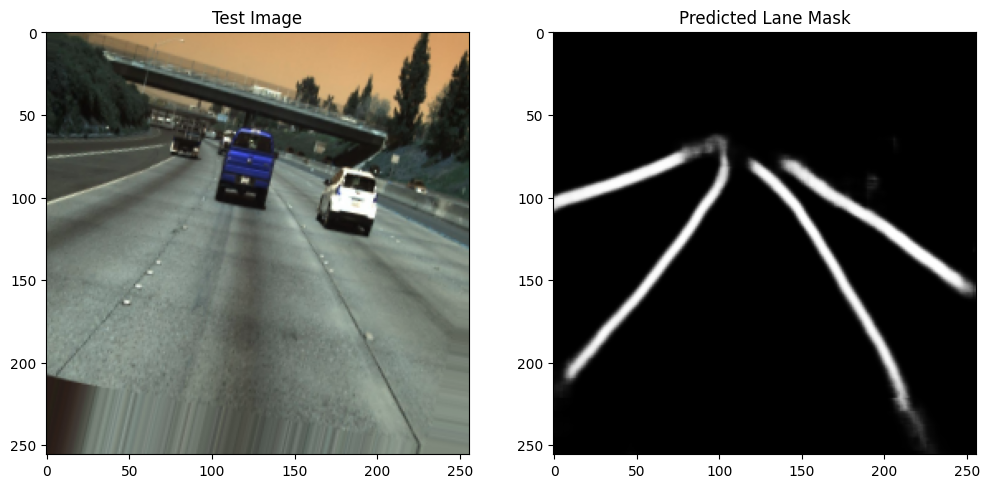

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


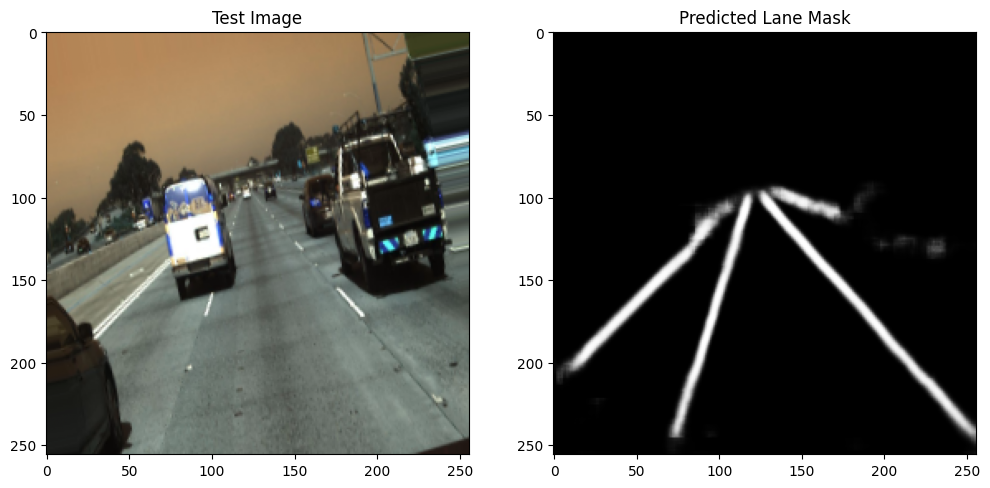

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


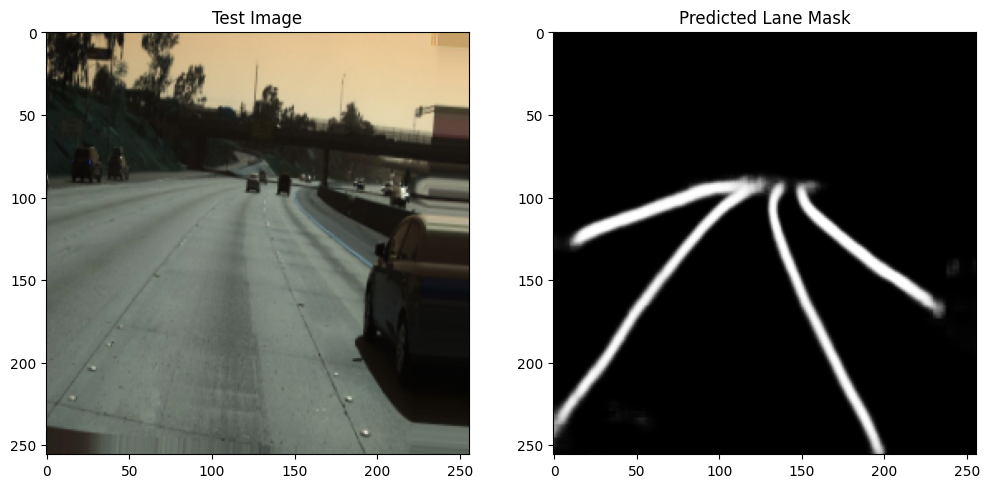

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


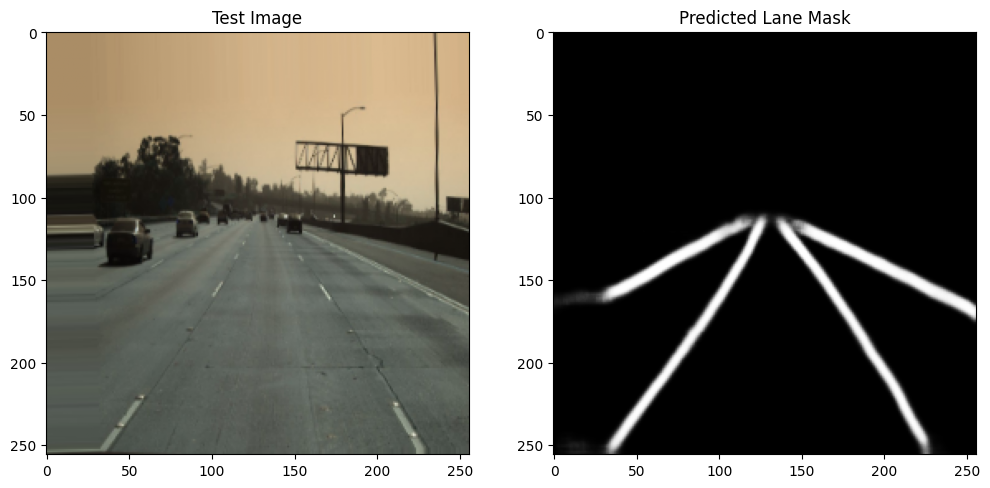

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


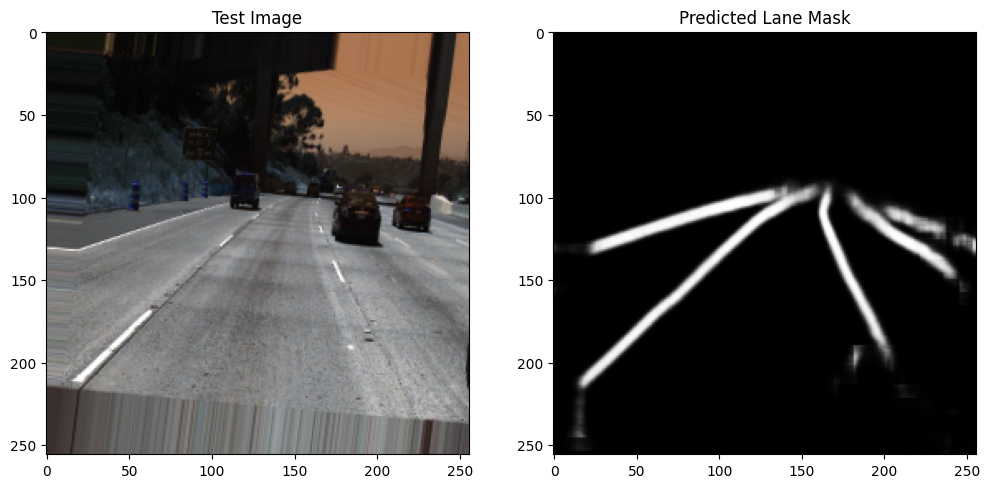

In [16]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt


test_frames_dir = '/kaggle/working/tusimple_preprocessed/test/frames'
test_masks_dir = '/kaggle/working/tusimple_preprocessed/test/lane-masks'

os.makedirs(test_frames_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)


training_frames = '/kaggle/working/tusimple_preprocessed/training/frames'
training_masks = '/kaggle/working/tusimple_preprocessed/training/lane-masks'


num_images_to_copy = 5
training_images = os.listdir(training_frames)[:num_images_to_copy]

for test_image_file in training_images:

    shutil.copy(os.path.join(training_frames, test_image_file), test_frames_dir)
    shutil.copy(os.path.join(training_masks, test_image_file), test_masks_dir)
    print(f"Copied {test_image_file} to test directories")


for test_image_file in training_images:
    test_image_path = os.path.join(test_frames_dir, test_image_file)
    test_mask_path = os.path.join(test_masks_dir, test_image_file)


    if not os.path.exists(test_image_path):
        print(f"Image file not found at: {test_image_path}")
        continue
    if not os.path.exists(test_mask_path):
        print(f"Mask file not found at: {test_mask_path}")
        continue


    test_image, test_mask = process_data(test_image_path, test_mask_path)

    predicted_mask = unet.predict(np.expand_dims(test_image, axis=0))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title('Test Image')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask[0], cmap='gray')
    plt.title('Predicted Lane Mask')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


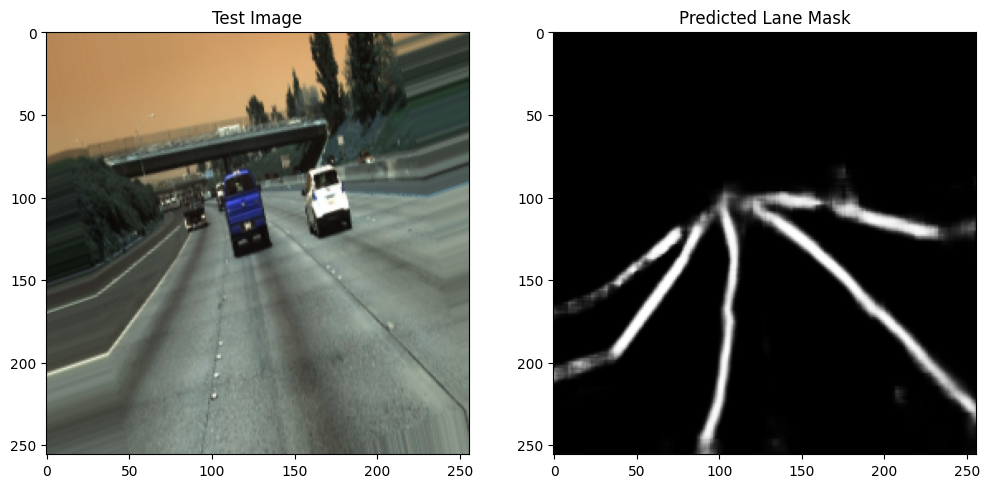

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


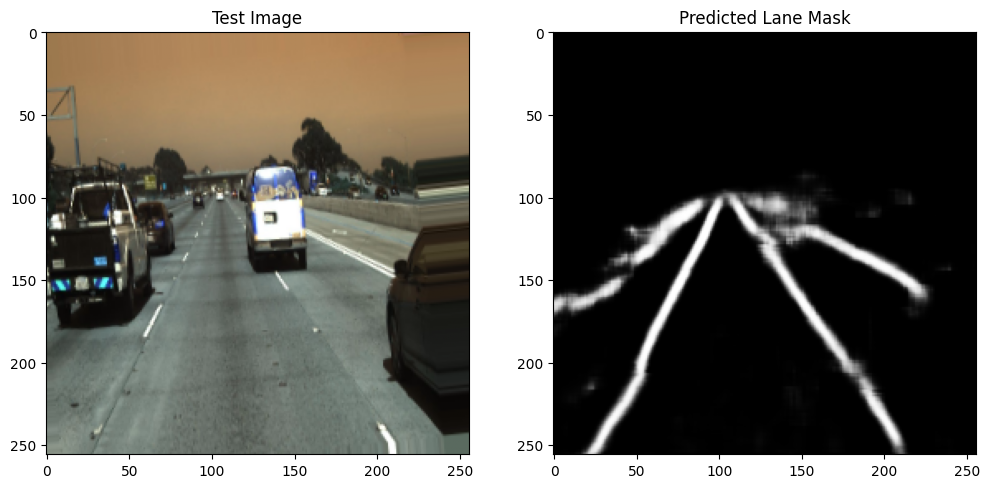

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


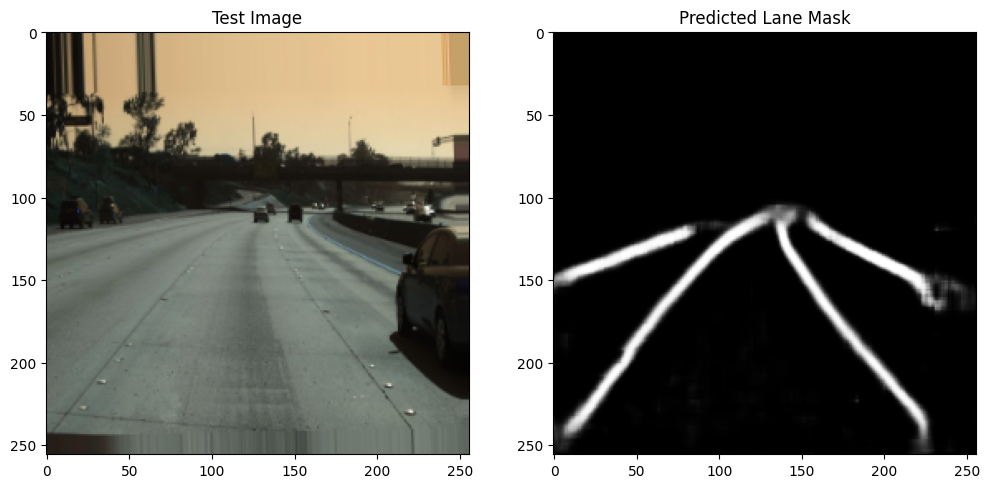

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


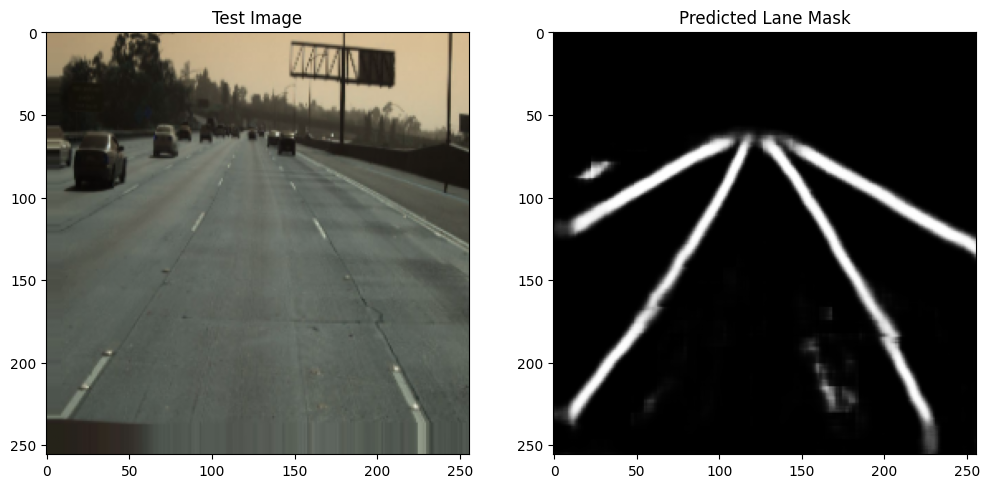

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


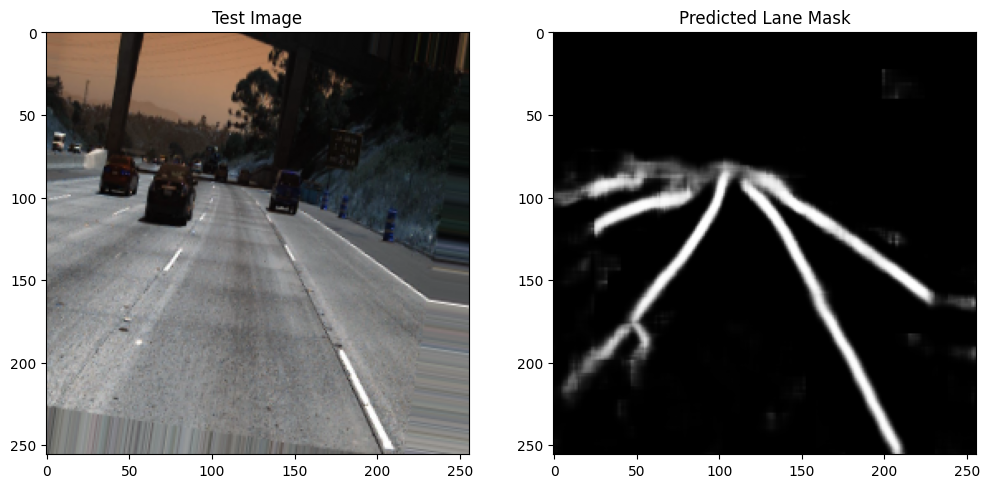

In [17]:
for test_image_file in training_images:
    test_image_path = os.path.join(test_frames_dir, test_image_file)
    test_mask_path = os.path.join(test_masks_dir, test_image_file)


    if not os.path.exists(test_image_path):
        print(f"Image file not found at: {test_image_path}")
        continue
    if not os.path.exists(test_mask_path):
        print(f"Mask file not found at: {test_mask_path}")
        continue

    test_image, test_mask = process_data(test_image_path, test_mask_path)


    predicted_mask = segnet.predict(np.expand_dims(test_image, axis=0))


    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title('Test Image')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask[0], cmap='gray')
    plt.title('Predicted Lane Mask')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
U-Net - Accuracy: 0.9741, Precision: 0.7927, Recall: 0.7432, F1 Score: 0.7672, IoU: 0.6223, Dice Coefficient: 0.7672


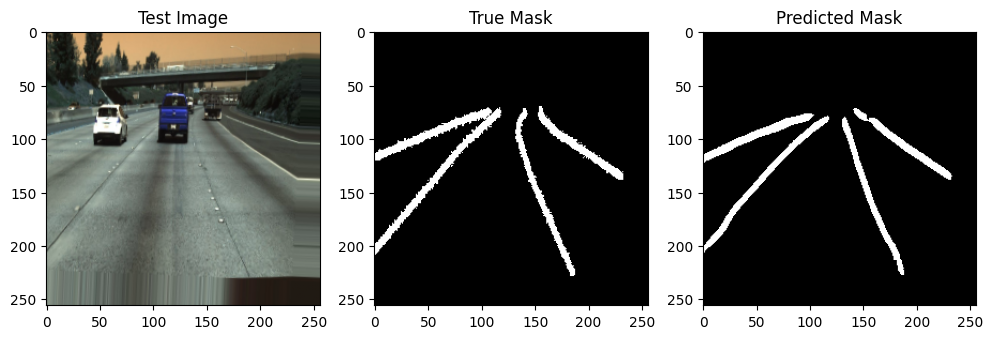

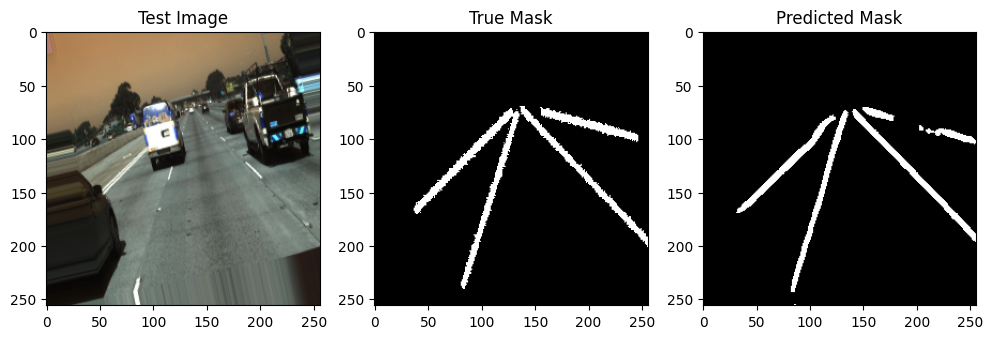

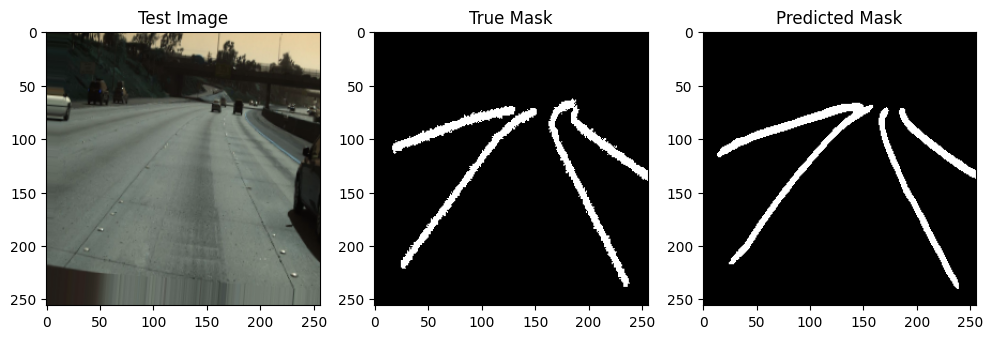

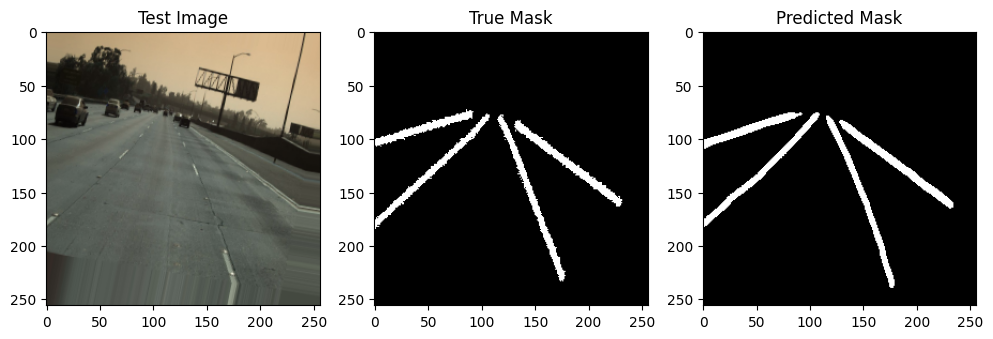

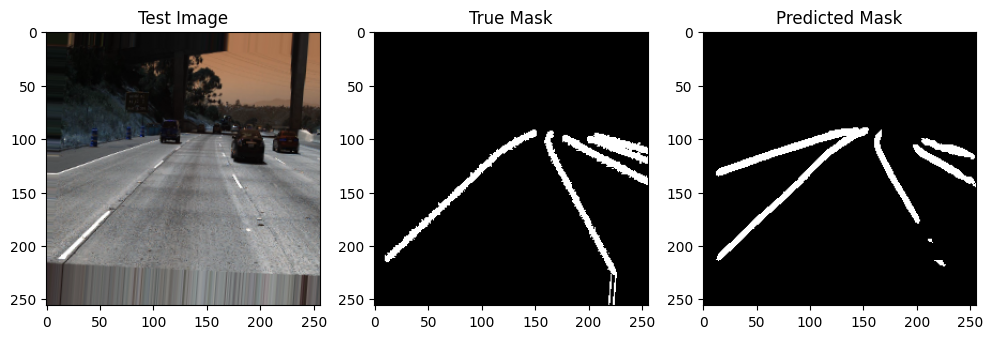

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
SegNet - Accuracy: 0.9707, Precision: 0.7674, Recall: 0.7031, F1 Score: 0.7338, IoU: 0.5796, Dice Coefficient: 0.7338


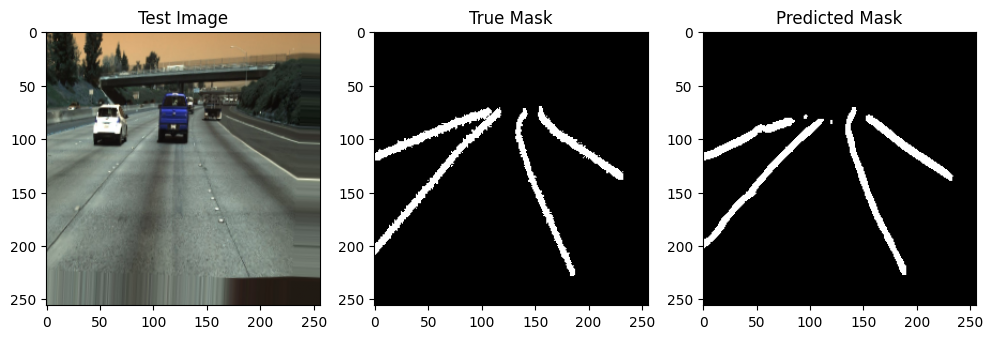

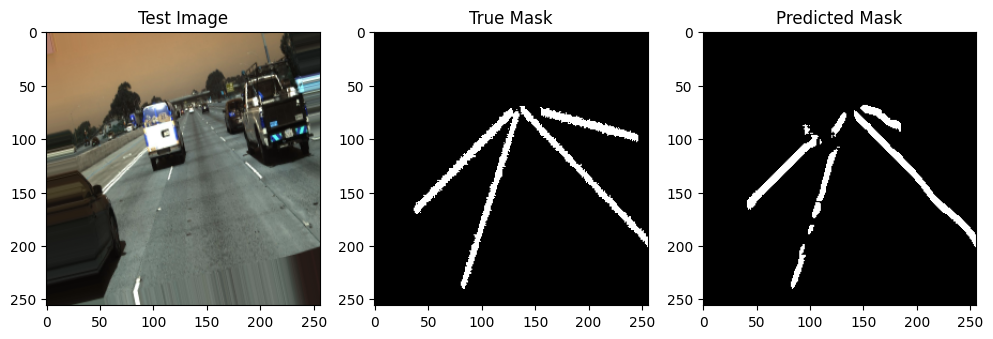

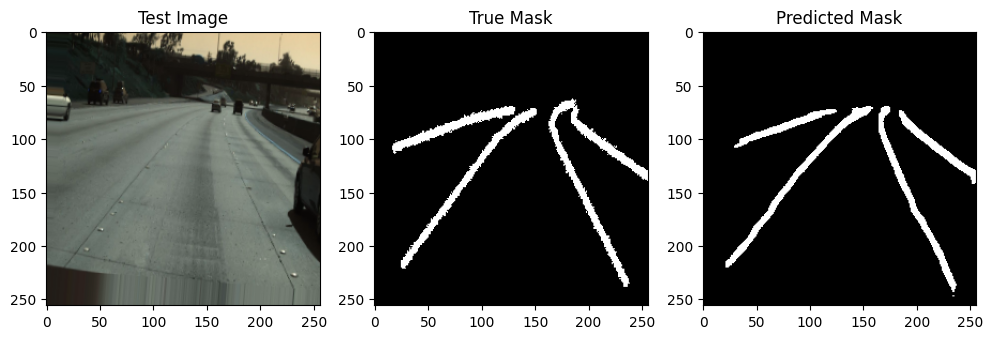

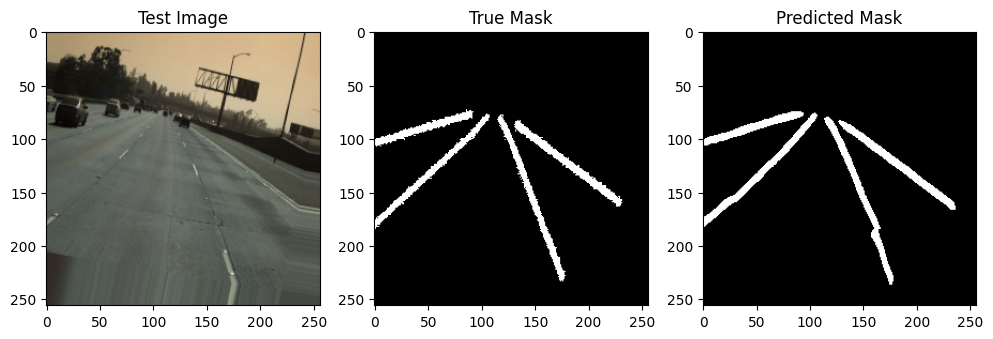

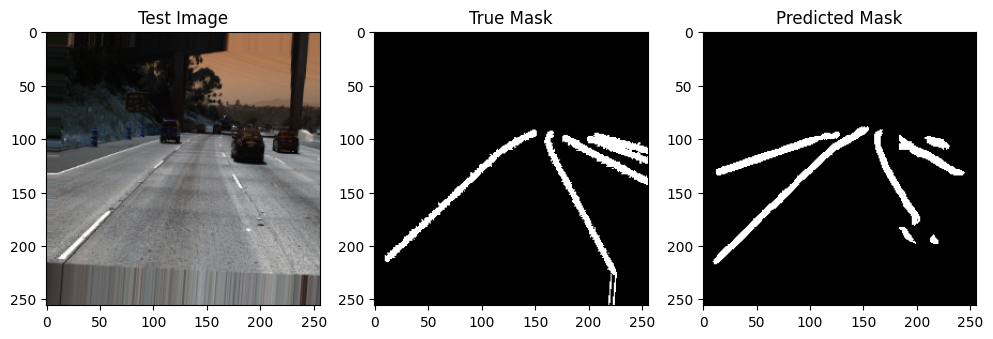

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score


def calculate_metrics(y_true, y_pred):

    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)
    iou = jaccard_score(y_true_flat, y_pred_flat)

    dice_coefficient = 2 * np.sum(y_true_flat * y_pred_flat) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-6)

    return accuracy, precision, recall, f1, iou, dice_coefficient


def evaluate_model(model, X_test, Y_test, model_name):

    predicted_masks = model.predict(X_test)


    predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)


    accuracy, precision, recall, f1, iou, dice_coefficient = calculate_metrics(Y_test, predicted_masks_binary)

    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
          f"F1 Score: {f1:.4f}, IoU: {iou:.4f}, Dice Coefficient: {dice_coefficient:.4f}")

    for i in range(min(5, len(X_test))): 
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i])
        plt.title('Test Image')

        plt.subplot(1, 3, 2)
        plt.imshow(Y_test[i], cmap='gray')
        plt.title('True Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks_binary[i], cmap='gray')
        plt.title('Predicted Mask')

        plt.show()


test_frames_dir = '/kaggle/working/tusimple_preprocessed/test/frames'
test_masks_dir = '/kaggle/working/tusimple_preprocessed/test/lane-masks'

X_test = []
Y_test = []
for test_image_file in os.listdir(test_frames_dir):
    test_image_path = os.path.join(test_frames_dir, test_image_file)
    test_mask_path = os.path.join(test_masks_dir, test_image_file)

   
    if not os.path.exists(test_image_path) or not os.path.exists(test_mask_path):
        print(f"Missing image or mask for: {test_image_file}")
        continue

    test_image, test_mask = process_data(test_image_path, test_mask_path)
    
    X_test.append(test_image)
    Y_test.append(test_mask)

X_test = np.array(X_test)
Y_test = np.array(Y_test)


if len(Y_test.shape) == 3:
    Y_test = np.expand_dims(Y_test, axis=-1) 
# Evaluate U-Net
evaluate_model(unet, X_test, Y_test, "U-Net")

# Evaluate SegNet
evaluate_model(segnet, X_test, Y_test, "SegNet")


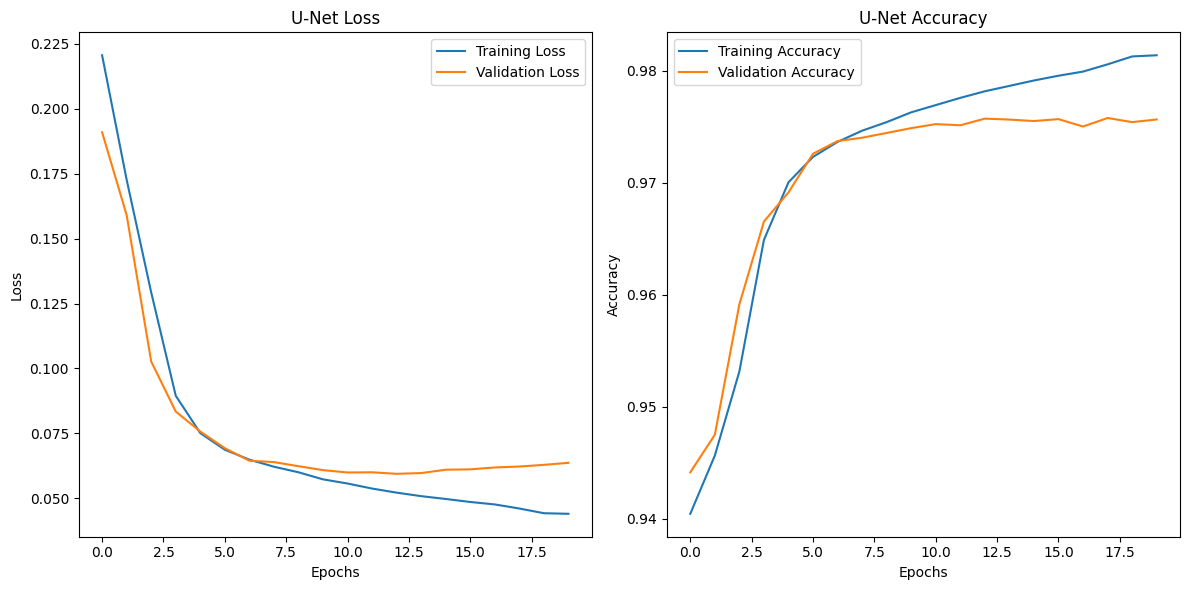

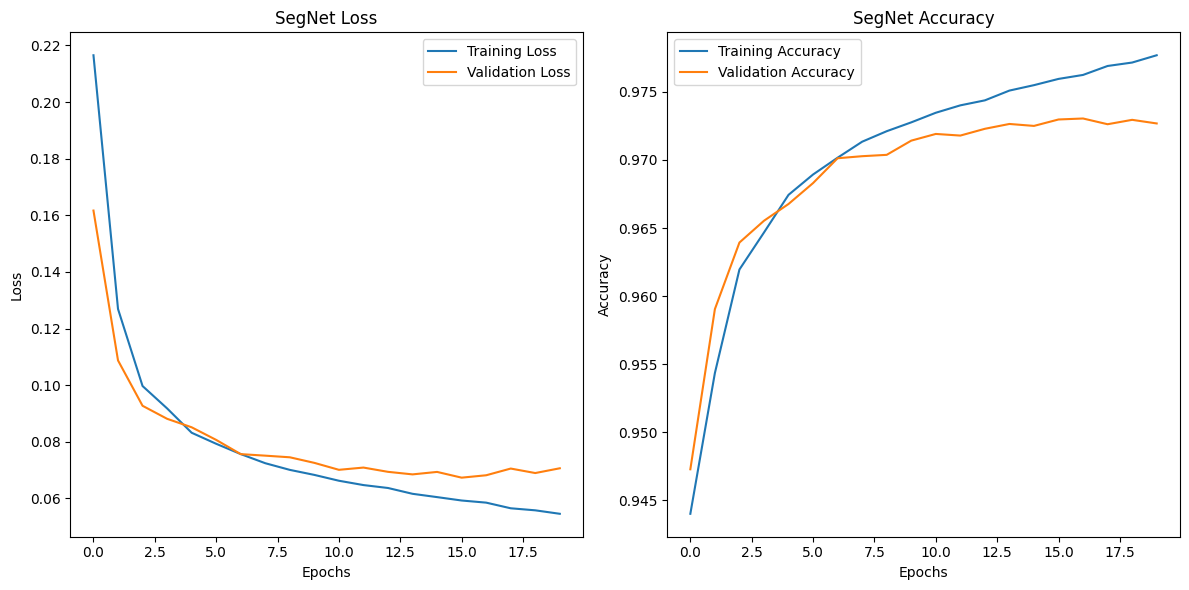

In [19]:
def plot_training_history(history, title):
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot U-Net training history
plot_training_history(history_unet, "U-Net")

# Plot SegNet training history
plot_training_history(history_segnet, "SegNet")


In [20]:
# Save U-Net model
unet.save('/kaggle/working/UNet_Model.keras')

# Save SegNet model
segnet.save('/kaggle/working/SegNet_Model.keras')